## Employee Retention Classification Model

* Problem Scope

Client is a HR Department at a IT software development company. They are rolling out a new program to increase employee retention. they want to use HR data and manually collected survey data to predict if a employee is likely to leave the company. These employees need to be identified proactively ( only perms not temps ). 

Data Source : once a employee leaves the company they have a exit interview where some of the datapoints are collected, the rest of the data is exported directly from workday HR database. Task is to build a classification model best as possible. Target Variable is Status. Input Features are the rest of the column features.

## 1. Describe data and its Sources, include preprocessing (8pts)

In [322]:
# print_function for compatibility with Python 3
from __future__ import print_function

# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)

# Matplotlib for visualization

import matplotlib
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline 

# Seaborn for easier visualization
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [323]:
# Load employee data from workday HR CSV
df1 = pd.read_csv('C:\\Users\\User\\Desktop\\employee_data.csv')
df1.head()

EmployeeID  avg_monthly_hrs   department  filed_complaint  last_evaluation  \
0           1              221  engineering              NaN         0.932868   
1           2              232      support              NaN              NaN   
2           3              184        sales              NaN         0.788830   
3           4              206        sales              NaN         0.575688   
4           5              249        sales              NaN         0.845217   

   n_projects  recently_promoted    status  tenure  
0           4                NaN      Left     5.0  
1           3                NaN  Employed     2.0  
2           3                NaN  Employed     3.0  
3           4                NaN  Employed     2.0  
4           3                NaN  Employed     3.0

In [324]:
import pandas_profiling
pandas_profiling.ProfileReport(df1)

In [325]:
#inspect survey exit data
df2 = pd.read_csv('C:\\Users\\User\\Desktop\\employee_dictKey.csv')
df2.head()

EmployeeID  salary  satisfaction  value
0           1     low      0.829896   65.0
1           2     low      0.834544   47.0
2           3  medium      0.834988   41.0
3           4     low      0.424764   97.0
4           5     low      0.779043   49.0

In [326]:
pandas_profiling.ProfileReport(df2)

### Merge Data sets

In [327]:
df = pd.merge(df1, df2[['EmployeeID', 'salary', 'satisfaction', 'value']],
                 on='EmployeeID')
##df = df.set_index([[0]])sets first column to index
df.head()

EmployeeID  avg_monthly_hrs   department  filed_complaint  last_evaluation  \
0           1              221  engineering              NaN         0.932868   
1           2              232      support              NaN              NaN   
2           3              184        sales              NaN         0.788830   
3           4              206        sales              NaN         0.575688   
4           5              249        sales              NaN         0.845217   

   n_projects  recently_promoted    status  tenure  salary  satisfaction  \
0           4                NaN      Left     5.0     low      0.829896   
1           3                NaN  Employed     2.0     low      0.834544   
2           3                NaN  Employed     3.0  medium      0.834988   
3           4                NaN  Employed     2.0     low      0.424764   
4           3                NaN  Employed     3.0     low      0.779043   

   value  
0   65.0  
1   47.0  
2   41.0  
3   97.0  
4   49.0

### Factor Descriptions

1. EmployeeID - Unique Employee Identifier
2. avg_monthly_hr - Average Hours worked in month
3. department - company department
4. filed_complaint - binary note if employee had ever had a complaint filed against
5. last_evaluation - last annual review score
6. n_projects - number of projects employee was assigned to.
7. recently_promoted - was the employee recently (within last 12 months)
8. Status - Current employment status
9. tenure - how many years with the company
10. salary - salary tier group
11. satisfaction - employee satisfaction survey score
12. value - companies calculated employee value

### Check Missing Values

In [328]:
df.isnull().sum()


EmployeeID               0
avg_monthly_hrs          0
department             709
filed_complaint      12191
last_evaluation       1532
n_projects               0
recently_promoted    13949
status                   0
tenure                 181
salary                   0
satisfaction           181
value                  149
dtype: int64

### Filling or Deleting Missing Values



In [329]:
#Factors to Fill with '0' - Filted Complain, recently promoted, Tensured
#Factors to predict fill, last_evaluation, satistifaction
#Relable defulat "department" with admin_ops ( administration operations)
df['filed_complaint'].fillna(0, inplace=True) # this has to be binary 0,1
df['recently_promoted'].fillna(0, inplace=True) # this has to be binary 0,1
df['tenure'].fillna(0, inplace=True) # this has to be 0 through years at company
df['department'].fillna('operations', inplace=True)
df.head()

EmployeeID  avg_monthly_hrs   department  filed_complaint  last_evaluation  \
0           1              221  engineering              0.0         0.932868   
1           2              232      support              0.0              NaN   
2           3              184        sales              0.0         0.788830   
3           4              206        sales              0.0         0.575688   
4           5              249        sales              0.0         0.845217   

   n_projects  recently_promoted    status  tenure  salary  satisfaction  \
0           4                0.0      Left     5.0     low      0.829896   
1           3                0.0  Employed     2.0     low      0.834544   
2           3                0.0  Employed     3.0  medium      0.834988   
3           4                0.0  Employed     2.0     low      0.424764   
4           3                0.0  Employed     3.0     low      0.779043   

   value  
0   65.0  
1   47.0  
2   41.0  
3   97.0  
4   49.0

In [330]:
#check data for missing still
df.isnull().sum()

EmployeeID              0
avg_monthly_hrs         0
department              0
filed_complaint         0
last_evaluation      1532
n_projects              0
recently_promoted       0
status                  0
tenure                  0
salary                  0
satisfaction          181
value                 149
dtype: int64

In [331]:
#fill value with mean
df['value'].fillna((df['value'].mean()), inplace=True)
df['satisfaction'].fillna((df['satisfaction'].mean()), inplace=True)
df['last_evaluation'].fillna((df['last_evaluation'].mean()), inplace=True)
df.isnull().sum()

EmployeeID           0
avg_monthly_hrs      0
department           0
filed_complaint      0
last_evaluation      0
n_projects           0
recently_promoted    0
status               0
tenure               0
salary               0
satisfaction         0
value                0
dtype: int64

### Data Exploration

In [332]:
df.shape # get number of rows and columns

(14249, 12)

In [333]:
df.info() # additional info about dataframe

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14249 entries, 0 to 14248
Data columns (total 12 columns):
EmployeeID           14249 non-null int64
avg_monthly_hrs      14249 non-null int64
department           14249 non-null object
filed_complaint      14249 non-null float64
last_evaluation      14249 non-null float64
n_projects           14249 non-null int64
recently_promoted    14249 non-null float64
status               14249 non-null object
tenure               14249 non-null float64
salary               14249 non-null object
satisfaction         14249 non-null float64
value                14249 non-null float64
dtypes: float64(6), int64(3), object(3)
memory usage: 1.4+ MB


In [334]:
#df.EmployeeID.value_counts()

In [335]:
# Summarize numerical features
df4 = df.describe().transpose() # statistical description, only for numeric values
df4

count         mean          std        min          25%  \
EmployeeID         14249.0  7125.000000  4113.476328   1.000000  3563.000000   
avg_monthly_hrs    14249.0   199.795775    50.998714  49.000000   155.000000   
filed_complaint    14249.0     0.144431     0.351539   0.000000     0.000000   
last_evaluation    14249.0     0.718477     0.163494   0.316175     0.579748   
n_projects         14249.0     3.773809     1.253126   1.000000     3.000000   
recently_promoted  14249.0     0.021054     0.143570   0.000000     0.000000   
tenure             14249.0     3.452804     1.503517   0.000000     3.000000   
satisfaction       14249.0     0.621295     0.248873   0.040058     0.453588   
value              14249.0    54.220284    25.893291  10.000000    32.000000   

                           50%           75%      max  
EmployeeID         7125.000000  10687.000000  14249.0  
avg_monthly_hrs     199.000000    245.000000    310.0  
filed_complaint       0.000000      0.000000      1.0  
last_evaluation       0.718477      0.856517      1.0  
n_projects            4.000000      5.000000      7.0  
recently_promoted     0.000000      0.000000      1.0  
tenure                3.000000      4.000000     10.0  
satisfaction          0.647489      0.822709      1.0  
value                54.000000     77.000000     99.0

In [336]:
#confirm numeric
df.apply(pd.to_numeric, errors='ignore')

df.dtypes

EmployeeID             int64
avg_monthly_hrs        int64
department            object
filed_complaint      float64
last_evaluation      float64
n_projects             int64
recently_promoted    float64
status                object
tenure               float64
salary                object
satisfaction         float64
value                float64
dtype: object

In [337]:
df['department'].unique()

array(['engineering', 'support', 'sales', 'IT', 'product', 'marketing',
       'temp', 'procurement', 'finance', 'operations', 'management',
       'information_technology', 'admin'], dtype=object)

### Reinput ordinale features classification

In [338]:
df['salary'] = df.salary.replace({'low': 0, 'medium': 1, 'high': 2})
df.head()

EmployeeID  avg_monthly_hrs   department  filed_complaint  last_evaluation  \
0           1              221  engineering              0.0         0.932868   
1           2              232      support              0.0         0.718477   
2           3              184        sales              0.0         0.788830   
3           4              206        sales              0.0         0.575688   
4           5              249        sales              0.0         0.845217   

   n_projects  recently_promoted    status  tenure  salary  satisfaction  \
0           4                0.0      Left     5.0       0      0.829896   
1           3                0.0  Employed     2.0       0      0.834544   
2           3                0.0  Employed     3.0       1      0.834988   
3           4                0.0  Employed     2.0       0      0.424764   
4           3                0.0  Employed     3.0       0      0.779043   

   value  
0   65.0  
1   47.0  
2   41.0  
3   97.0  
4   49.0

## Data Visualizations Explorations

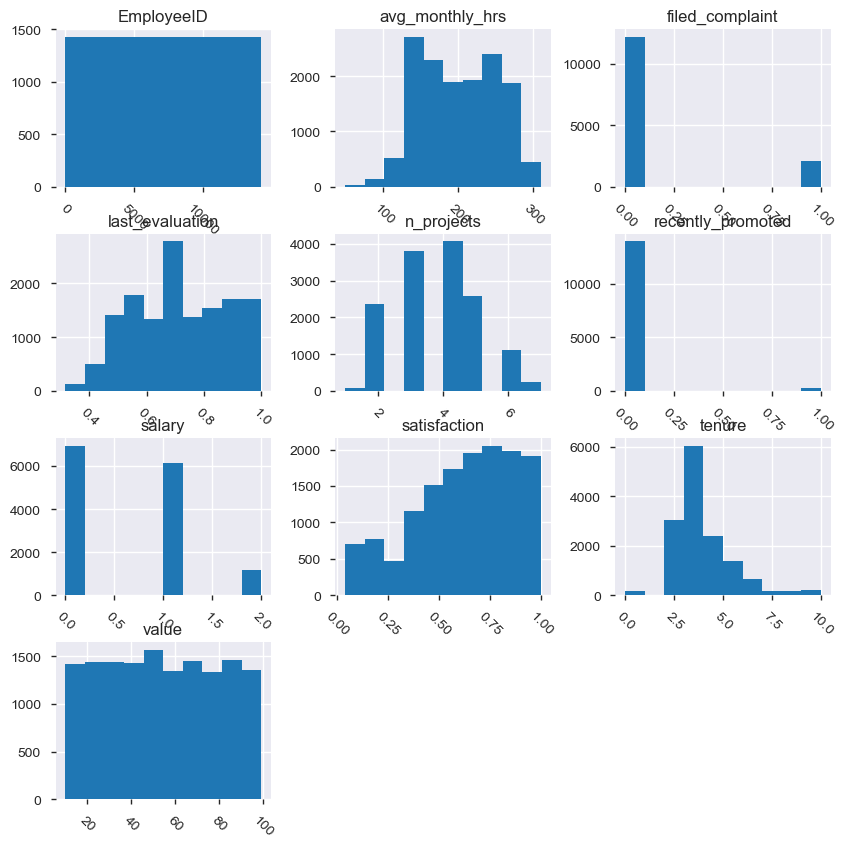

In [339]:
# Plot histogram grid Distributions
df.hist(figsize=(10,10), xrot=-45)

# Clear the text "residue"
plt.show()

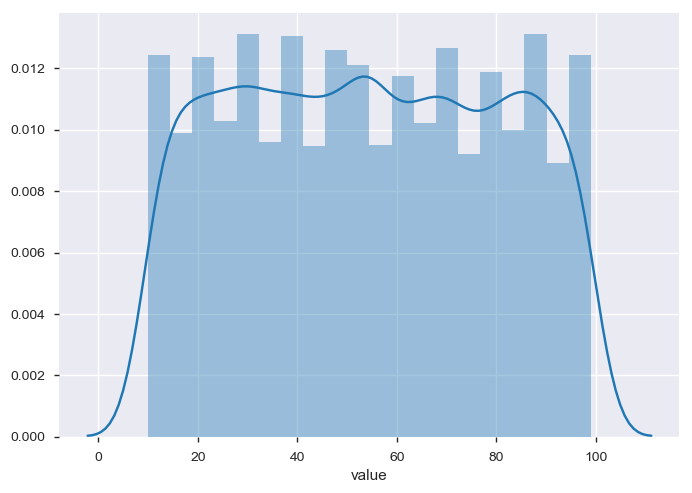

In [340]:
sns.distplot( df["value"], bins=20 )
#sns.plt.show()

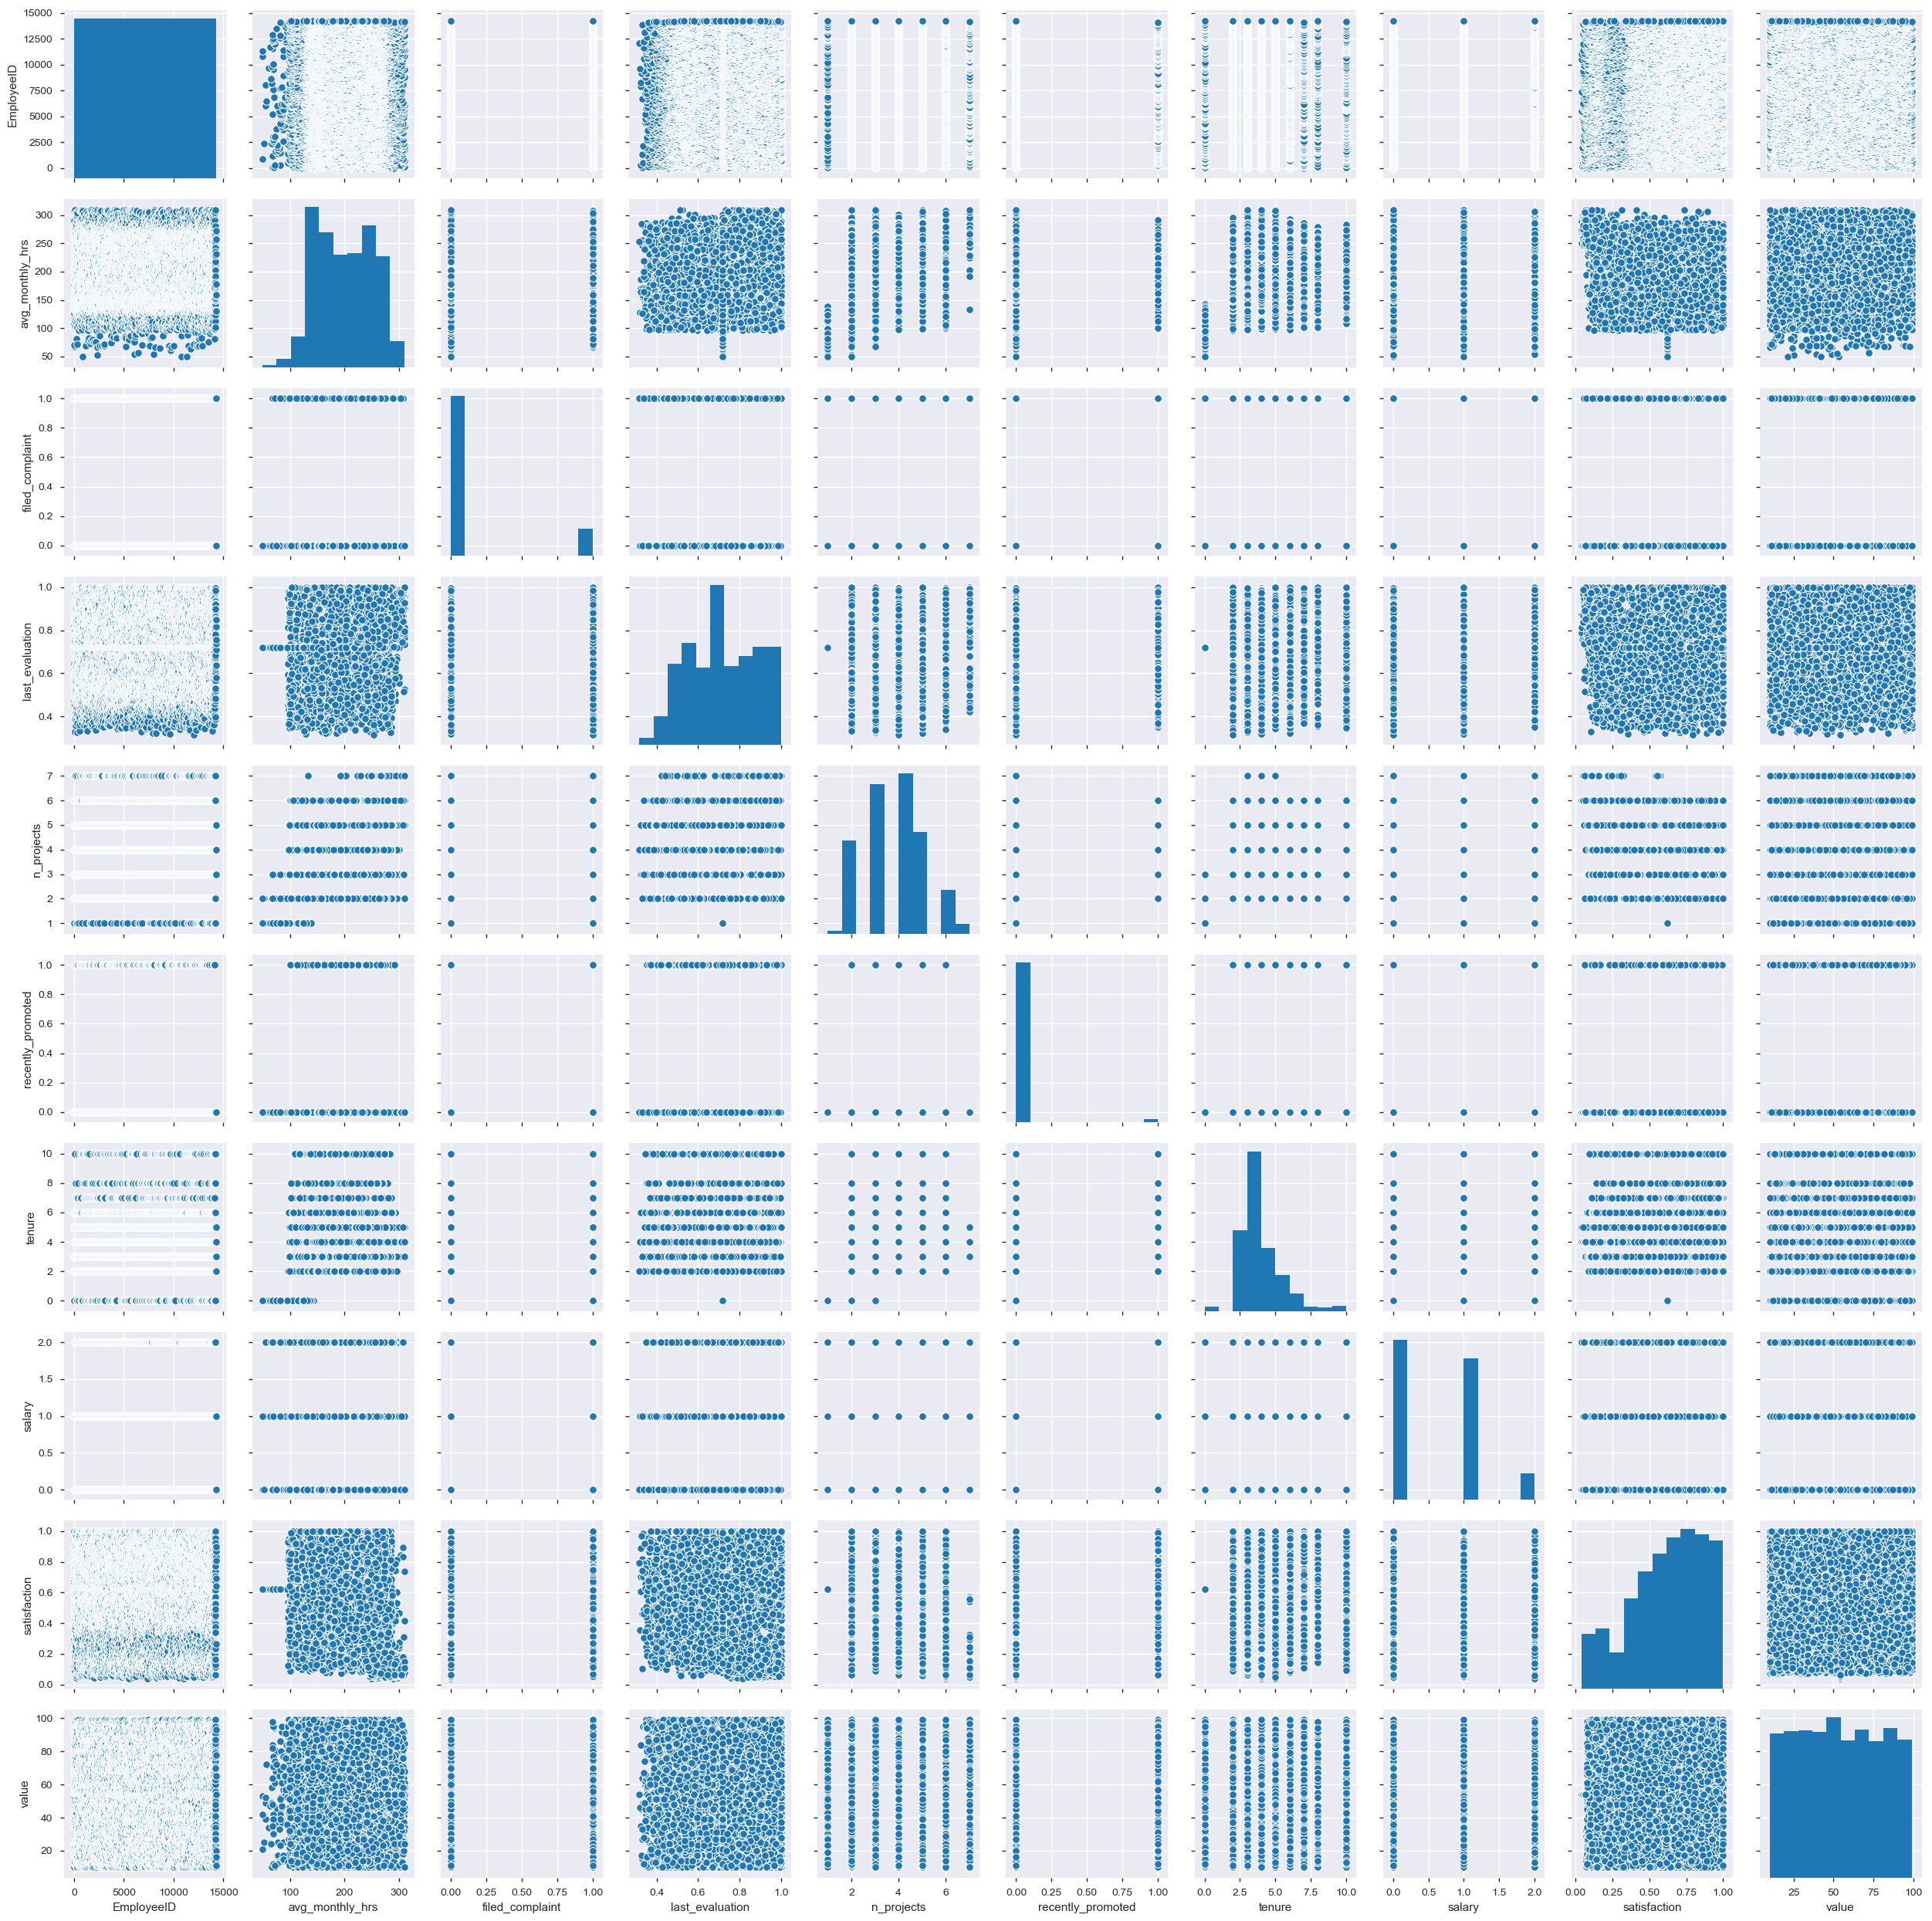

In [341]:
# Basic correlogram
sns.pairplot(df)
#sns.plt.show()

### Categorical Groups Data Inspection

In [342]:
## Inspect the data for grouped by Department
df.groupby('department').mean()

EmployeeID  avg_monthly_hrs  filed_complaint  \
department                                                              
IT                      7359.223945       202.175711         0.131783   
admin                   6965.619318       201.272727         0.096591   
engineering             7261.347608       202.469522         0.138889   
finance                 6963.975275       201.175824         0.119505   
information_technology  7015.861244       202.167464         0.191388   
management              7095.914286       201.025210         0.173109   
marketing               7217.010989       199.664225         0.159951   
operations              7447.918195       198.833568         0.122708   
procurement             6989.235632       199.482759         0.183908   
product                 7059.470930       199.991860         0.151163   
sales                   7045.570482       200.842467         0.141728   
support                 6961.688973       200.975495         0.155042   
temp                    7091.110497        99.690608         0.182320   

                        last_evaluation  n_projects  recently_promoted  \
department                                                               
IT                             0.720477    3.806202           0.001723   
admin                          0.725306    3.897727           0.028409   
engineering                    0.721969    3.872299           0.010031   
finance                        0.723412    3.815934           0.019231   
information_technology         0.716400    3.832536           0.023923   
management                     0.728638    3.857143           0.114286   
marketing                      0.715373    3.687424           0.048840   
operations                     0.717978    3.672779           0.021157   
procurement                    0.701198    3.885057           0.057471   
product                        0.719494    3.817442           0.000000   
sales                          0.711902    3.772878           0.024726   
support                        0.722737    3.804430           0.008483   
temp                           0.718477    1.657459           0.000000   

                          tenure    salary  satisfaction      value  
department                                                           
IT                      3.481481  0.561585      0.628324  53.788478  
admin                   3.369318  0.596591      0.611450  56.911594  
engineering             3.402392  0.564815      0.617907  54.965591  
finance                 3.543956  0.641484      0.586787  53.507286  
information_technology  3.315789  0.631579      0.626717  53.942584  
management              4.294118  1.057143      0.630428  52.306623  
marketing               3.567766  0.620269      0.629122  54.509012  
operations              3.366714  0.606488      0.604360  53.533121  
procurement             3.264368  0.557471      0.627930  53.913793  
product                 3.487209  0.577907      0.628774  54.279306  
sales                   3.527148  0.556207      0.623075  53.898983  
support                 3.394910  0.554194      0.626923  54.699164  
temp                    0.000000  0.602210      0.621295  55.928177

In [343]:
## Inspect the data for grouped by Department
df.groupby('salary').mean()

EmployeeID  avg_monthly_hrs  filed_complaint  last_evaluation  \
salary                                                                   
0       7133.592923       200.015247         0.141254         0.720006   
1       7140.812236       199.647576         0.145135         0.718714   
2       6988.666377       199.261512         0.159861         0.707970   

        n_projects  recently_promoted    tenure  satisfaction      value  
salary                                                                    
0         3.773878           0.009350  3.394850      0.608174  54.199822  
1         3.778392           0.027009  3.480801      0.631262  54.298695  
2         3.748914           0.059948  3.653345      0.647333  53.925179

In [344]:
## Inspect the data for grouped by Department
df.groupby('status').mean()

EmployeeID  avg_monthly_hrs  filed_complaint  last_evaluation  \
status                                                                     
Employed  7140.414479       197.700286         0.175187         0.714948   
Left      7075.661851       206.502948         0.045991         0.729772   

          n_projects  recently_promoted    tenure    salary  satisfaction  \
status                                                                      
Employed    3.755273           0.025974  3.331675  0.648061      0.675193   
Left        3.833137           0.005307  3.840507  0.416274      0.448781   

              value  
status               
Employed  54.365683  
Left      53.754894

### Turnover comparison analysis

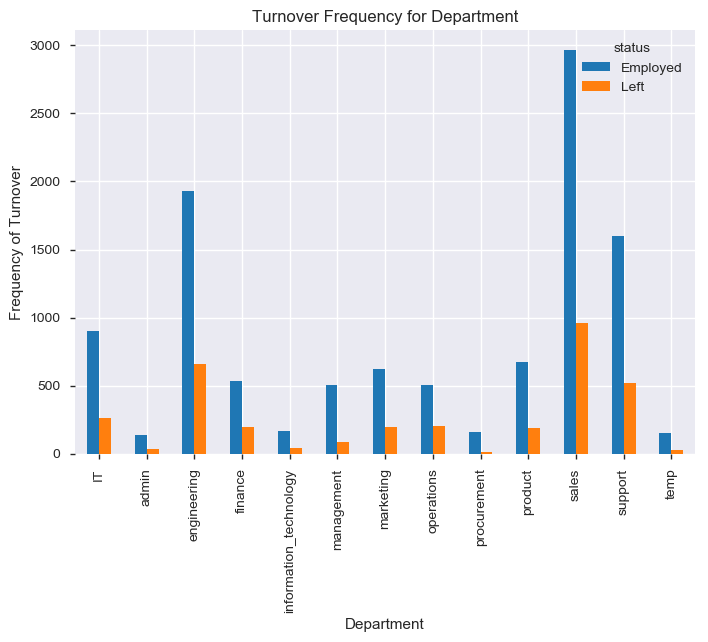

In [345]:
pd.crosstab(df.department,df.status).plot(kind='bar')
plt.title('Turnover Frequency for Department')
plt.xlabel('Department')
plt.ylabel('Frequency of Turnover')
plt.savefig('department_bar_chart')

### Salary Level and Frequency of Turnover Analysis

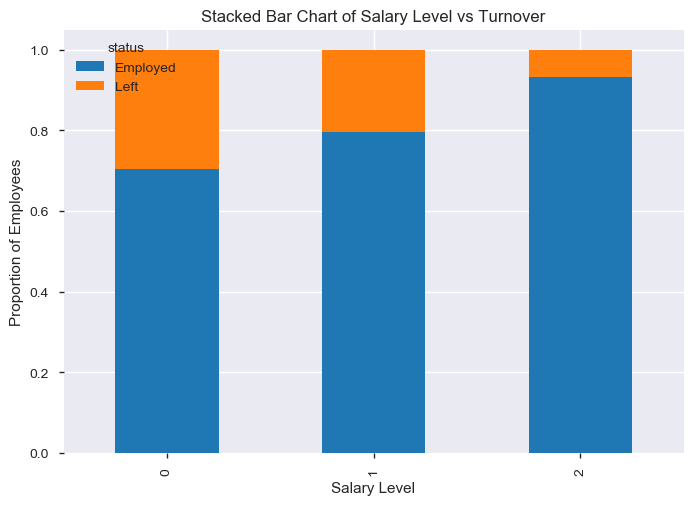

In [346]:
table=pd.crosstab(df.salary, df.status)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Salary Level vs Turnover')
plt.xlabel('Salary Level')
plt.ylabel('Proportion of Employees')
plt.savefig('salary_bar_chart')

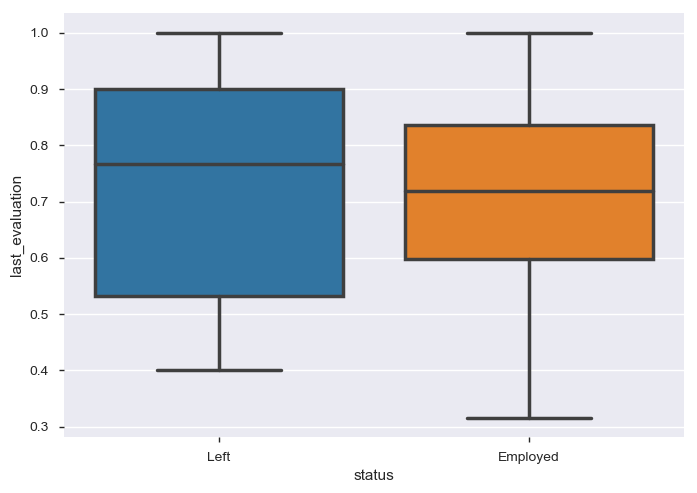

In [347]:
sns.boxplot(x="status", y="last_evaluation", data=df, linewidth=2.5)

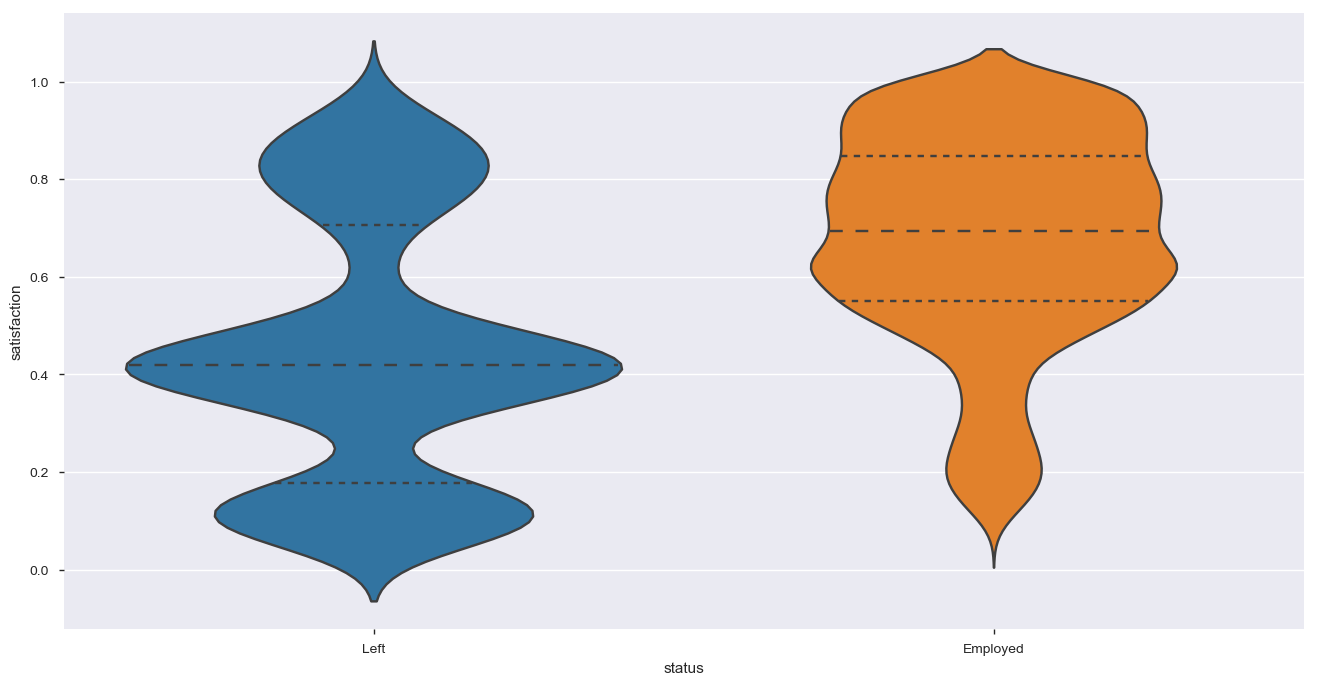

In [348]:
f, ax = plt.subplots(figsize=(16, 8))
sns.violinplot(x="status", y="satisfaction",
               split=True, inner="quart",data=df)
sns.despine(left=True)

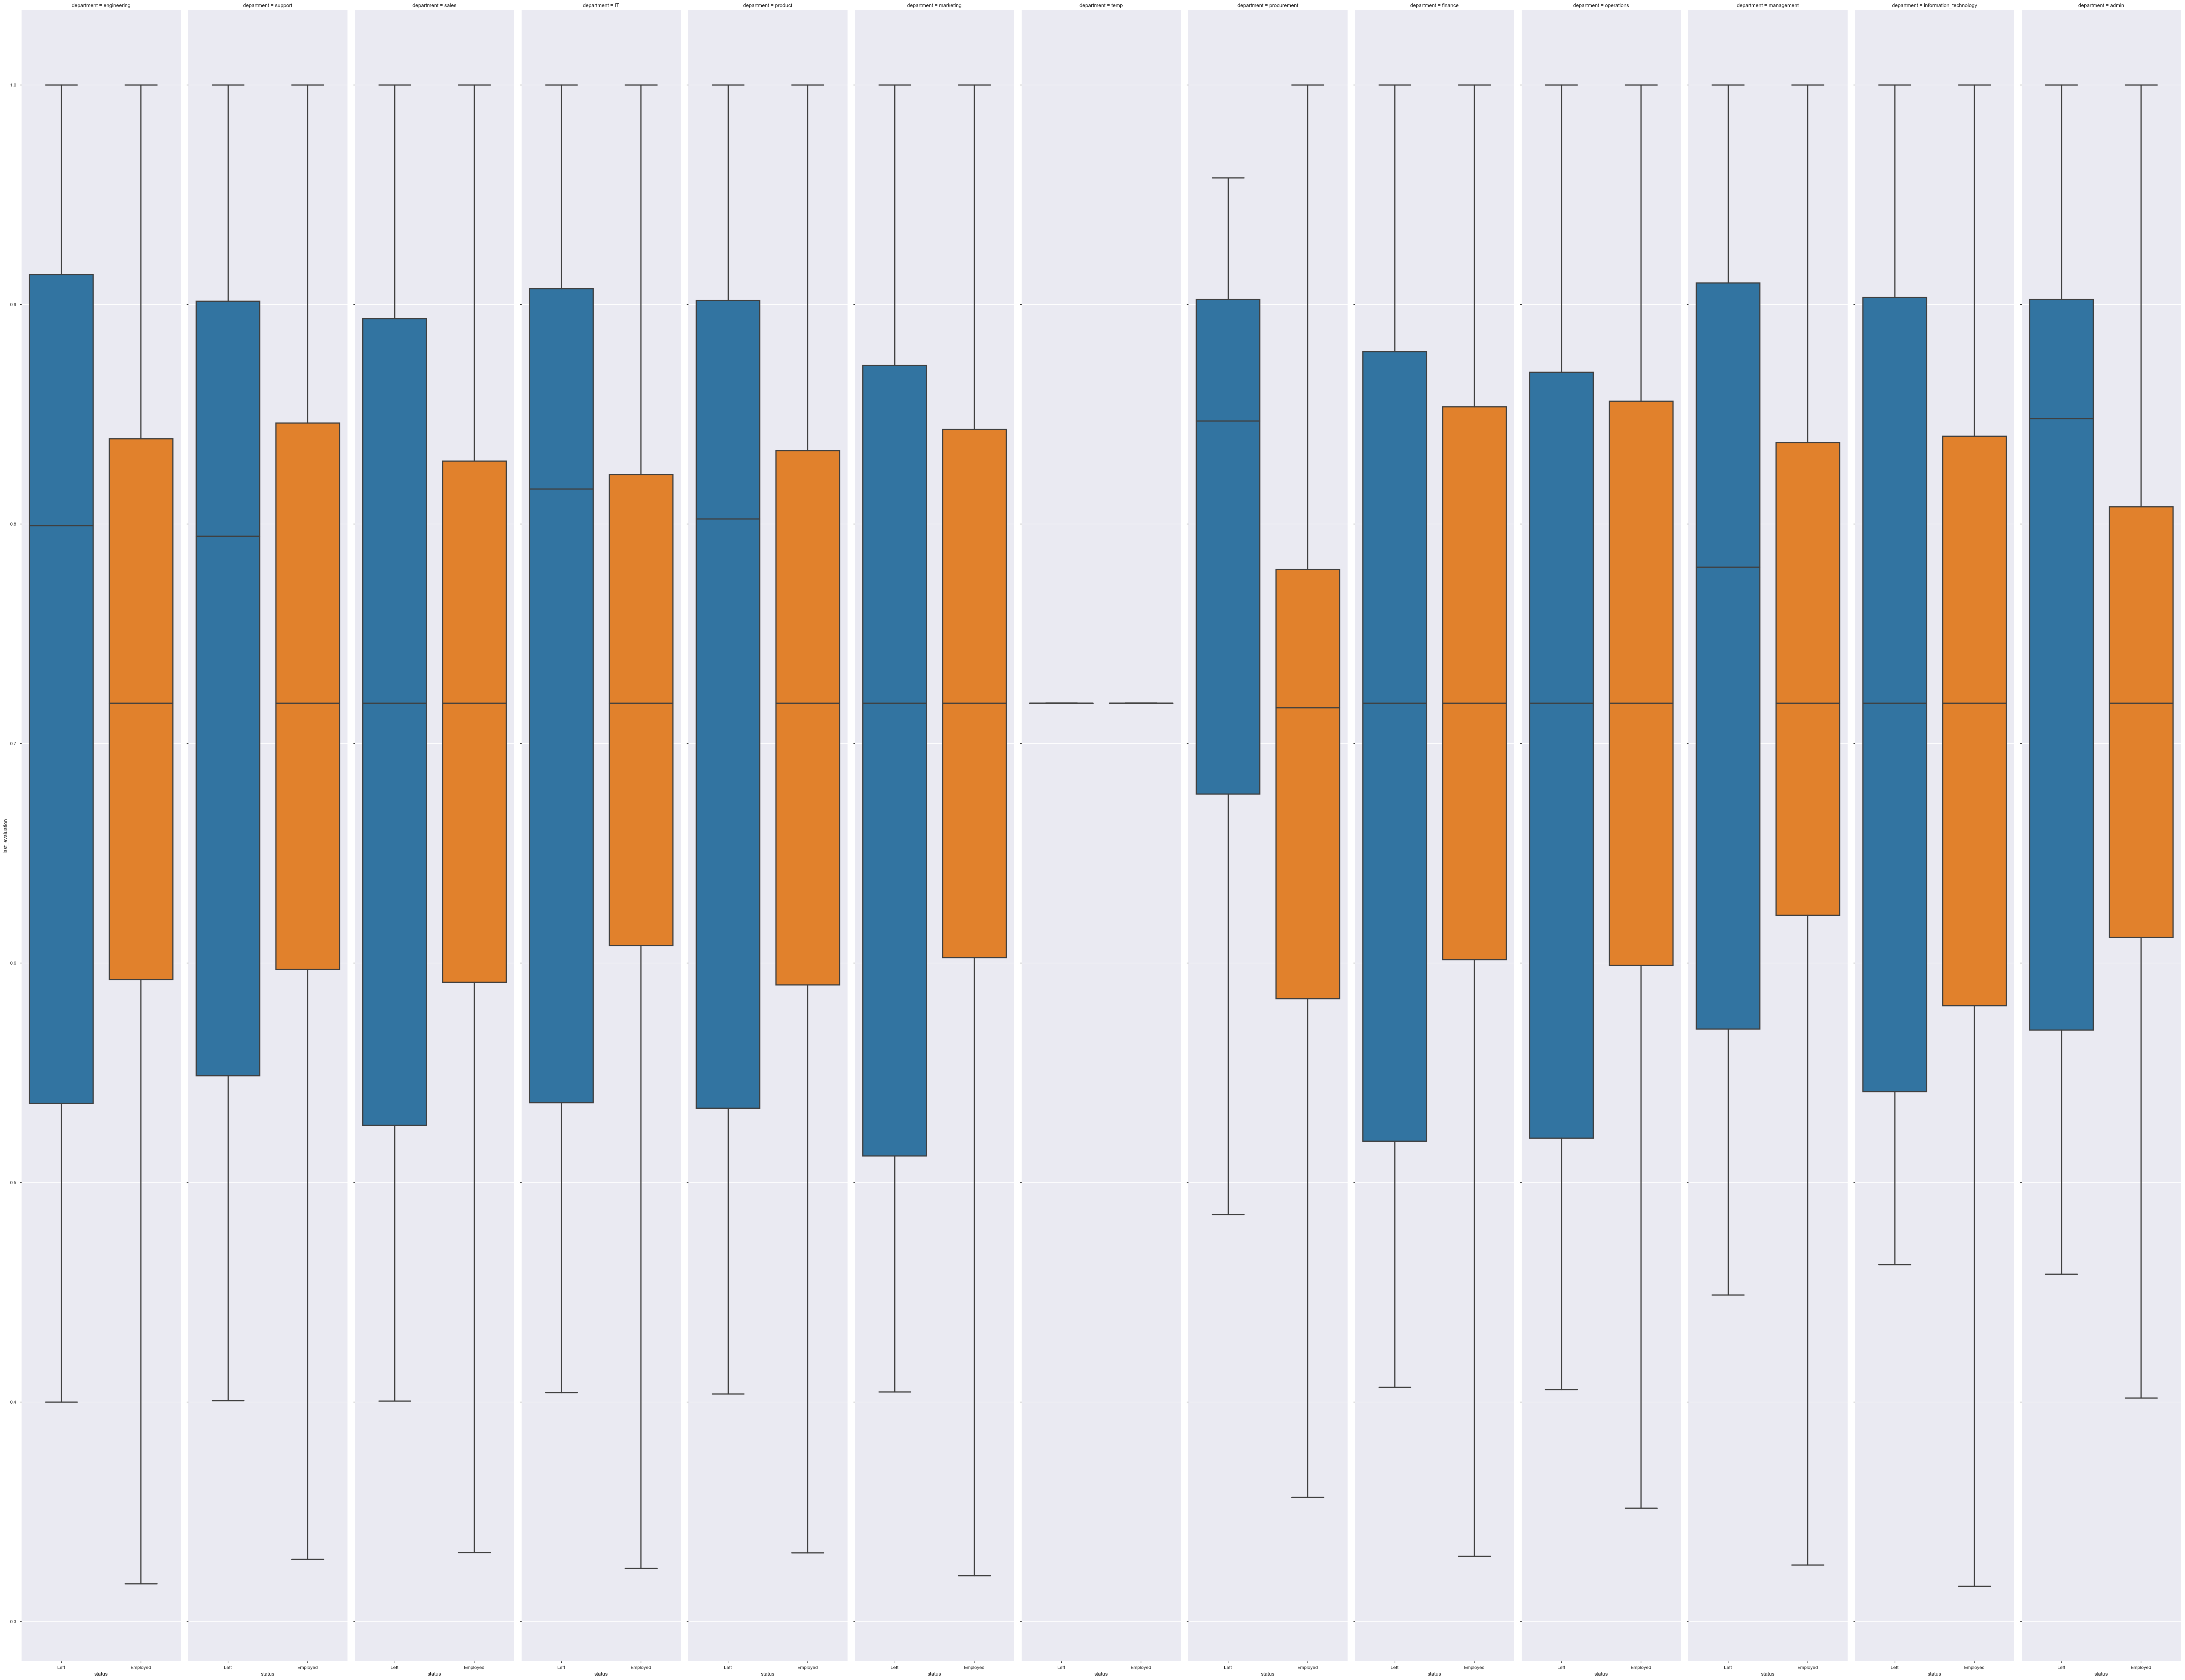

In [349]:
sns.catplot(x="status", y="last_evaluation", col="department",data=df, kind="box", height=50, aspect=.1, linewidth=2.5)

In [350]:
df.head()

EmployeeID  avg_monthly_hrs   department  filed_complaint  last_evaluation  \
0           1              221  engineering              0.0         0.932868   
1           2              232      support              0.0         0.718477   
2           3              184        sales              0.0         0.788830   
3           4              206        sales              0.0         0.575688   
4           5              249        sales              0.0         0.845217   

   n_projects  recently_promoted    status  tenure  salary  satisfaction  \
0           4                0.0      Left     5.0       0      0.829896   
1           3                0.0  Employed     2.0       0      0.834544   
2           3                0.0  Employed     3.0       1      0.834988   
3           4                0.0  Employed     2.0       0      0.424764   
4           3                0.0  Employed     3.0       0      0.779043   

   value  
0   65.0  
1   47.0  
2   41.0  
3   97.0  
4   49.0

In [351]:
left = df[df.status != 'Employed']
left.head()

EmployeeID  avg_monthly_hrs   department  filed_complaint  \
0            1              221  engineering              0.0   
10          11              147        sales              0.0   
13          14              290  engineering              0.0   
15          16              258      support              0.0   
17          18              252           IT              0.0   

    last_evaluation  n_projects  recently_promoted status  tenure  salary  \
0          0.932868           4                0.0   Left     5.0       0   
10         0.718477           2                0.0   Left     3.0       1   
13         0.770248           6                0.0   Left     4.0       1   
15         0.837503           5                0.0   Left     5.0       1   
17         0.919196           5                0.0   Left     5.0       0   

    satisfaction  value  
0       0.829896   65.0  
10      0.403552   32.0  
13      0.090343   25.0  
15      0.849667   34.0  
17      0.893365   80.0

In [352]:
left.describe().transpose()

count         mean          std        min          25%  \
EmployeeID         3392.0  7075.661851  4109.896697   1.000000  3452.500000   
avg_monthly_hrs    3392.0   206.502948    61.753651  63.000000   146.000000   
filed_complaint    3392.0     0.045991     0.209496   0.000000     0.000000   
last_evaluation    3392.0     0.729772     0.189812   0.400060     0.531564   
n_projects         3392.0     3.833137     1.825760   1.000000     2.000000   
recently_promoted  3392.0     0.005307     0.072664   0.000000     0.000000   
tenure             3392.0     3.840507     1.024431   0.000000     3.000000   
salary             3392.0     0.416274     0.538196   0.000000     0.000000   
satisfaction       3392.0     0.448781     0.264921   0.040058     0.176959   
value              3392.0    53.754894    25.413591  10.000000    32.000000   

                           50%           75%           max  
EmployeeID         7052.500000  10651.000000  14247.000000  
avg_monthly_hrs     222.500000    262.000000    310.000000  
filed_complaint       0.000000      0.000000      1.000000  
last_evaluation       0.766067      0.900582      1.000000  
n_projects            4.000000      6.000000      7.000000  
recently_promoted     0.000000      0.000000      1.000000  
tenure                4.000000      5.000000      6.000000  
salary                0.000000      1.000000      2.000000  
satisfaction          0.418925      0.706922      0.979577  
value                54.220284     75.000000     99.000000

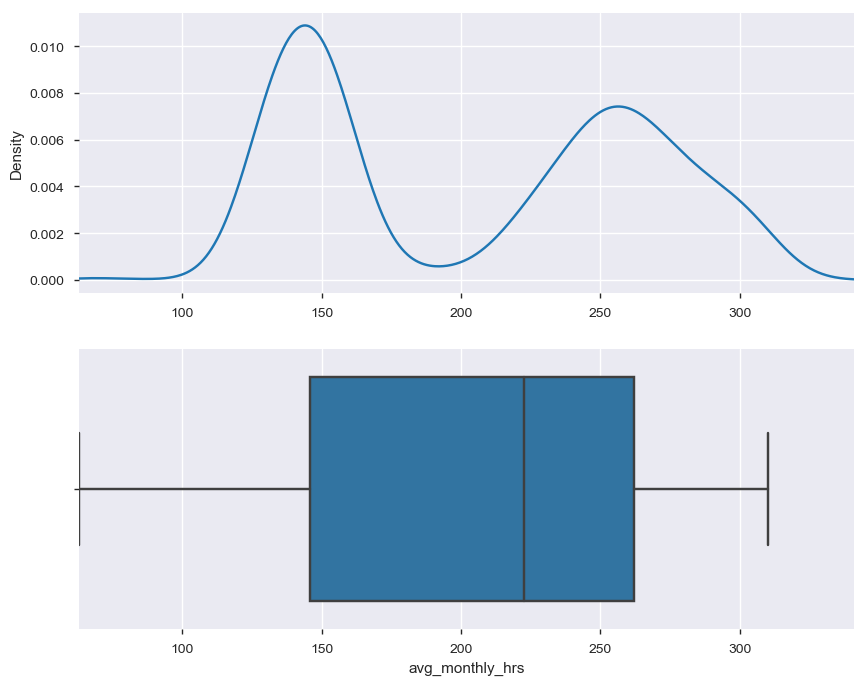

In [353]:
q75, q25 = np.percentile(left.avg_monthly_hrs, [75 ,25])
iqr = q75 - q25
 
min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5)

i = 'avg_monthly_hrs'
 
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(left[i].min(), left[i].max()*1.1)
plt.axvline(x=min)
plt.axvline(x=max)
 
ax = left[i].plot(kind='kde')
 
plt.subplot(212)
plt.xlim(left[i].min(), left[i].max()*1.1)
sns.boxplot(x=left[i])
plt.axvline(x=min)
plt.axvline(x=max)

In [354]:
stay = df[df.status != 'Left']
stay.head()

EmployeeID  avg_monthly_hrs department  filed_complaint  last_evaluation  \
1           2              232    support              0.0         0.718477   
2           3              184      sales              0.0         0.788830   
3           4              206      sales              0.0         0.575688   
4           5              249      sales              0.0         0.845217   
5           6              140      sales              0.0         0.589097   

   n_projects  recently_promoted    status  tenure  salary  satisfaction  \
1           3                0.0  Employed     2.0       0      0.834544   
2           3                0.0  Employed     3.0       1      0.834988   
3           4                0.0  Employed     2.0       0      0.424764   
4           3                0.0  Employed     3.0       0      0.779043   
5           4                0.0  Employed     4.0       1      0.660020   

   value  
1   47.0  
2   41.0  
3   97.0  
4   49.0  
5   30.0

In [355]:
stay.describe().transpose()

count         mean          std        min          25%  \
EmployeeID         10857.0  7140.414479  4114.661932   2.000000  3596.000000   
avg_monthly_hrs    10857.0   197.700286    46.945468  49.000000   160.000000   
filed_complaint    10857.0     0.175187     0.380144   0.000000     0.000000   
last_evaluation    10857.0     0.714948     0.154194   0.316175     0.598380   
n_projects         10857.0     3.755273     1.009113   1.000000     3.000000   
recently_promoted  10857.0     0.025974     0.159065   0.000000     0.000000   
tenure             10857.0     3.331675     1.605439   0.000000     2.000000   
salary             10857.0     0.648061     0.652375   0.000000     0.000000   
satisfaction       10857.0     0.675193     0.217172   0.072554     0.550492   
value              10857.0    54.365683    26.040800  10.000000    32.000000   

                           50%           75%      max  
EmployeeID         7143.000000  10693.000000  14249.0  
avg_monthly_hrs     197.000000    238.000000    287.0  
filed_complaint       0.000000      0.000000      1.0  
last_evaluation       0.718477      0.835036      1.0  
n_projects            4.000000      4.000000      6.0  
recently_promoted     0.000000      0.000000      1.0  
tenure                3.000000      4.000000     10.0  
salary                1.000000      1.000000      2.0  
satisfaction          0.693730      0.847051      1.0  
value                54.000000     77.000000     99.0

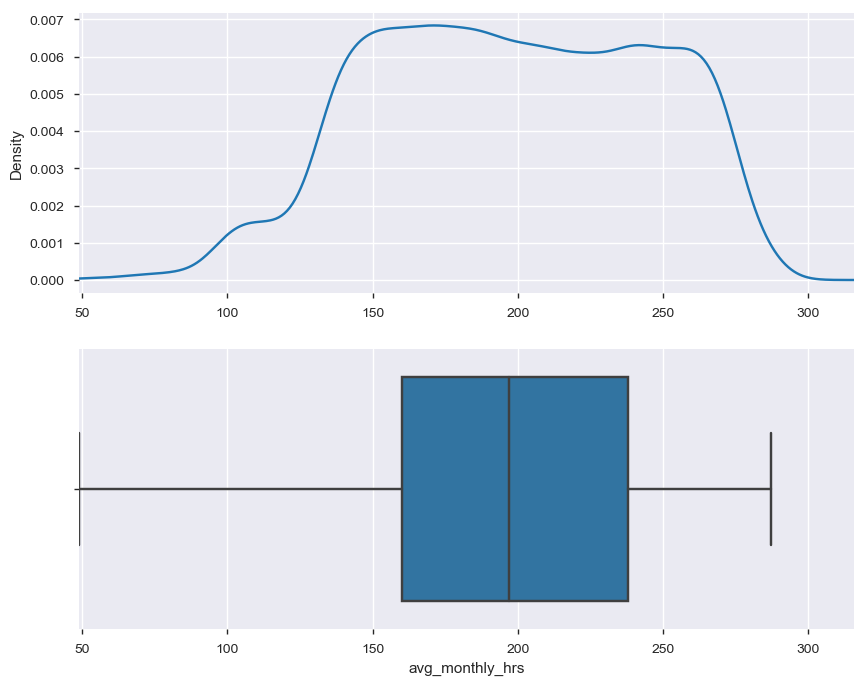

In [239]:
q75, q25 = np.percentile(stay.avg_monthly_hrs, [75 ,25])
iqr = q75 - q25
 
min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5)

k = 'avg_monthly_hrs'
 
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(stay[k].min(), stay[k].max()*1.1)
plt.axvline(x=min)
plt.axvline(x=max)
 
ax = stay[k].plot(kind='kde')
 
plt.subplot(212)
plt.xlim(stay[k].min(), stay[k].max()*1.1)
sns.boxplot(x=stay[k])
plt.axvline(x=min)
plt.axvline(x=max)

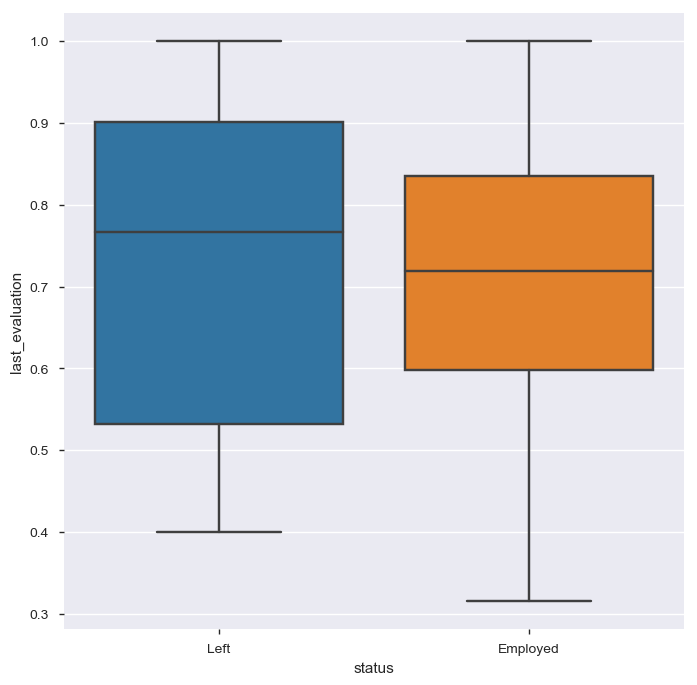

In [360]:
f, ax = plt.subplots(figsize=(8, 8))

sns.boxplot(x="status", y="last_evaluation", data=df)


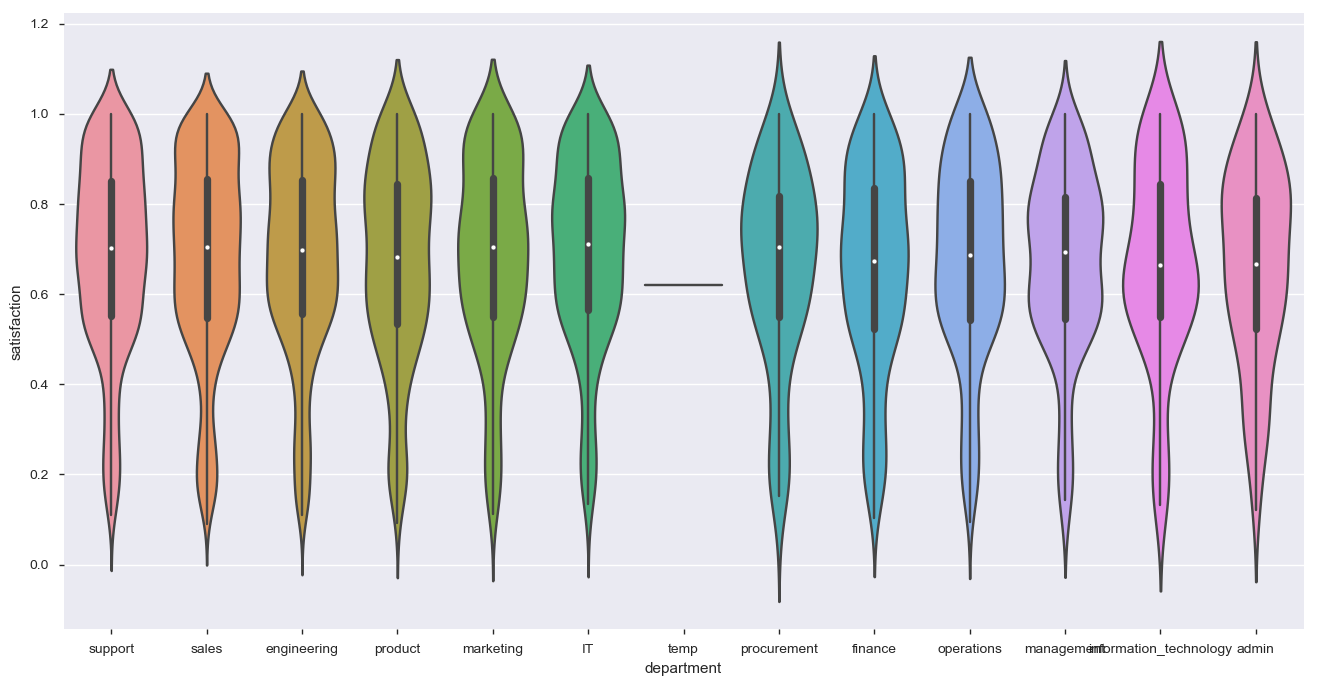

In [241]:
f, ax = plt.subplots(figsize=(16, 8))
sns.violinplot(x="department", y="satisfaction", data=stay)

In [242]:
print("Median of left Satisfaction: %f" % left['satisfaction'].median())
print("Median of stay Satisfaction: %f" % stay['satisfaction'].median())

print("Skewness of left Satisfaction: %f" % left['satisfaction'].skew())
print("Kurtosis of left Satisfaction: %f" % left['satisfaction'].kurt())

print("Skewness of stay Satisfaction: %f" % stay['satisfaction'].skew())
print("Kurtosis of stay Satisfaction: %f" % stay['satisfaction'].kurt())

Median of left Satisfaction: 0.418925
Median of stay Satisfaction: 0.693730
Skewness of left Satisfaction: 0.295615
Kurtosis of left Satisfaction: -0.986510
Skewness of stay Satisfaction: -0.608682
Kurtosis of stay Satisfaction: -0.166401


In [243]:
print("Median of left Value: %f" % left['value'].median())
print("Median of stay Value: %f" % stay['value'].median())

print("Skewness of left Value: %f" % left['value'].skew())
print("Kurtosis of left Value: %f" % left['value'].kurt())

print("Skewness of stay Value: %f" % stay['value'].skew())
print("Kurtosis of stay Value: %f" % stay['value'].kurt())

Median of left Value: 54.220284
Median of stay Value: 54.000000
Skewness of left Value: 0.044218
Kurtosis of left Value: -1.122753
Skewness of stay Value: 0.009831
Kurtosis of stay Value: -1.208796


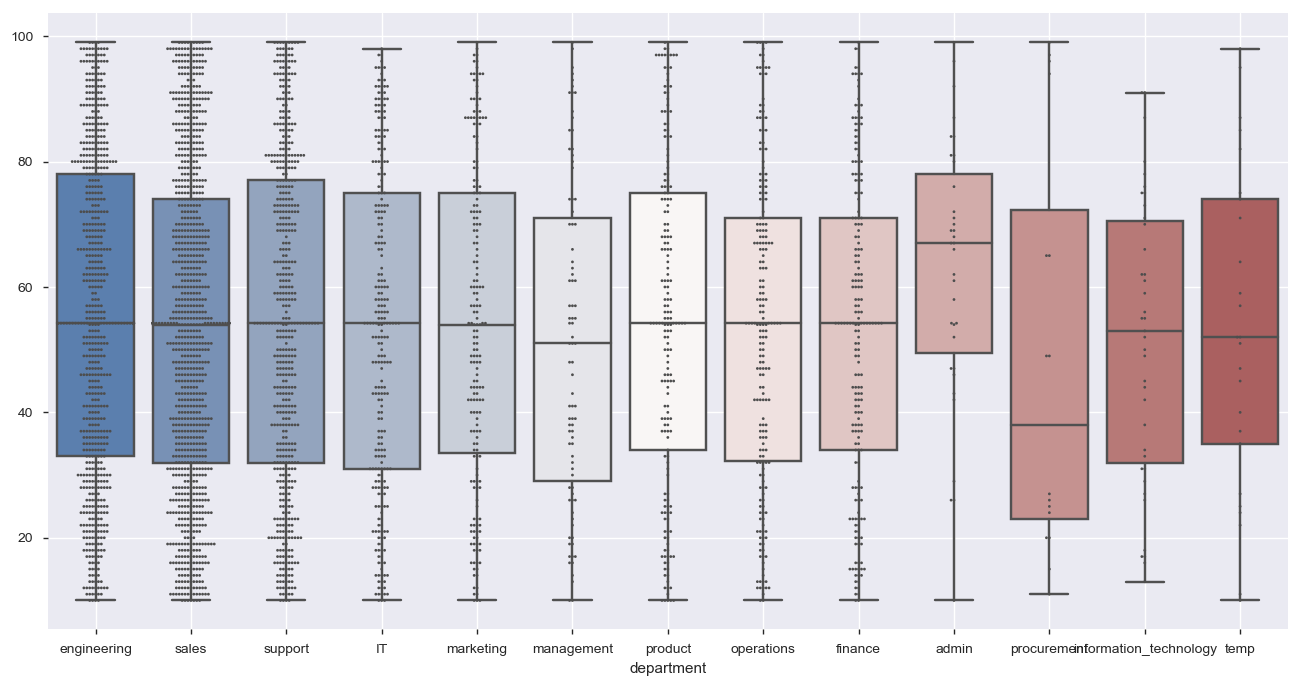

In [244]:
f, ax = plt.subplots(figsize=(16, 8))
# Plot the orbital period with horizontal boxes
sns.boxplot(x="department", y="value", data=left,
            whis="range", palette="vlag")

# Add in points to show each observation
sns.swarmplot(x="department", y="value", data=left,
              size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

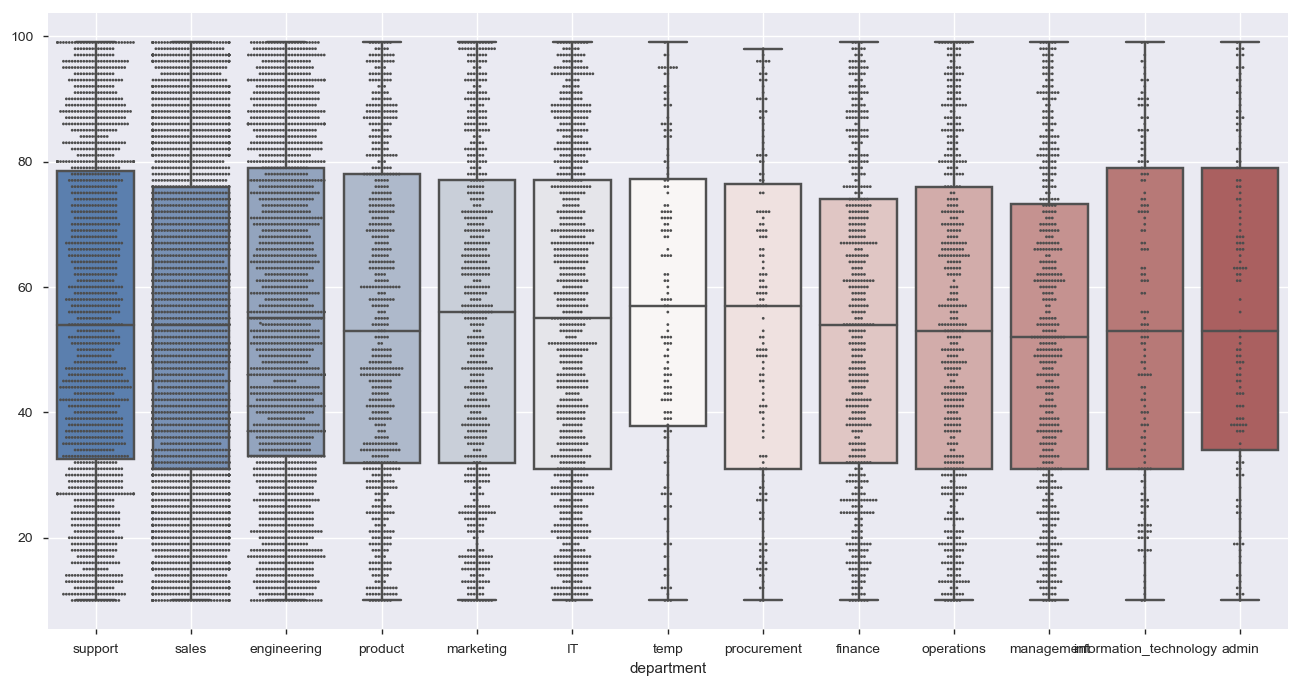

In [245]:
f, ax = plt.subplots(figsize=(16, 8))
# Plot the orbital period with horizontal boxes
sns.boxplot(x="department", y="value", data=stay,
            whis="range", palette="vlag")

# Add in points to show each observation
sns.swarmplot(x="department", y="value", data=stay,
              size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

Text(0,0.5,'Proportion of Employees')

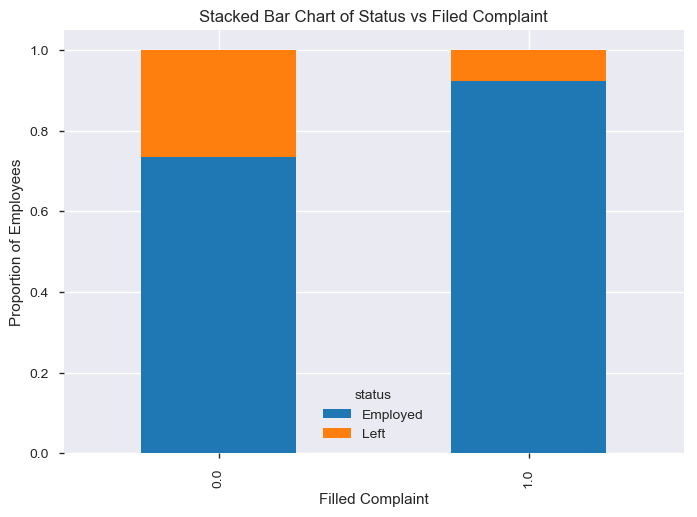

In [364]:
table=pd.crosstab(df.filed_complaint, df.status)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Status vs Filed Complaint')
plt.xlabel('Filled Complaint')
plt.ylabel('Proportion of Employees')


In [246]:
correlations = df.corr()
correlations

EmployeeID  avg_monthly_hrs  filed_complaint  \
EmployeeID           1.000000        -0.008804         0.001787   
avg_monthly_hrs     -0.008804         1.000000        -0.009265   
filed_complaint      0.001787        -0.009265         1.000000   
last_evaluation      0.007641         0.316718        -0.013794   
n_projects           0.005046         0.443221        -0.005337   
recently_promoted   -0.002223         0.002533         0.042651   
tenure               0.000636         0.175431         0.003735   
salary              -0.005823        -0.004641         0.012532   
satisfaction         0.020760        -0.019100         0.055901   
value                0.009775        -0.003794        -0.014195   

                   last_evaluation  n_projects  recently_promoted    tenure  \
EmployeeID                0.007641    0.005046          -0.002223  0.000636   
avg_monthly_hrs           0.316718    0.443221           0.002533  0.175431   
filed_complaint          -0.013794   -0.005337           0.042651  0.003735   
last_evaluation           1.000000    0.325261          -0.007901  0.124704   
n_projects                0.325261    1.000000          -0.001616  0.232203   
recently_promoted        -0.007901   -0.001616           1.000000  0.070933   
tenure                    0.124704    0.232203           0.070933  1.000000   
salary                   -0.015369   -0.002571           0.097138  0.046602   
satisfaction              0.086088   -0.140657           0.025794 -0.093941   
value                     0.007703   -0.011060           0.009933 -0.011417   

                     salary  satisfaction     value  
EmployeeID        -0.005823      0.020760  0.009775  
avg_monthly_hrs   -0.004641     -0.019100 -0.003794  
filed_complaint    0.012532      0.055901 -0.014195  
last_evaluation   -0.015369      0.086088  0.007703  
n_projects        -0.002571     -0.140657 -0.011060  
recently_promoted  0.097138      0.025794  0.009933  
tenure             0.046602     -0.093941 -0.011417  
salary             1.000000      0.053841 -0.000843  
satisfaction       0.053841      1.000000  0.018681  
value             -0.000843      0.018681  1.000000

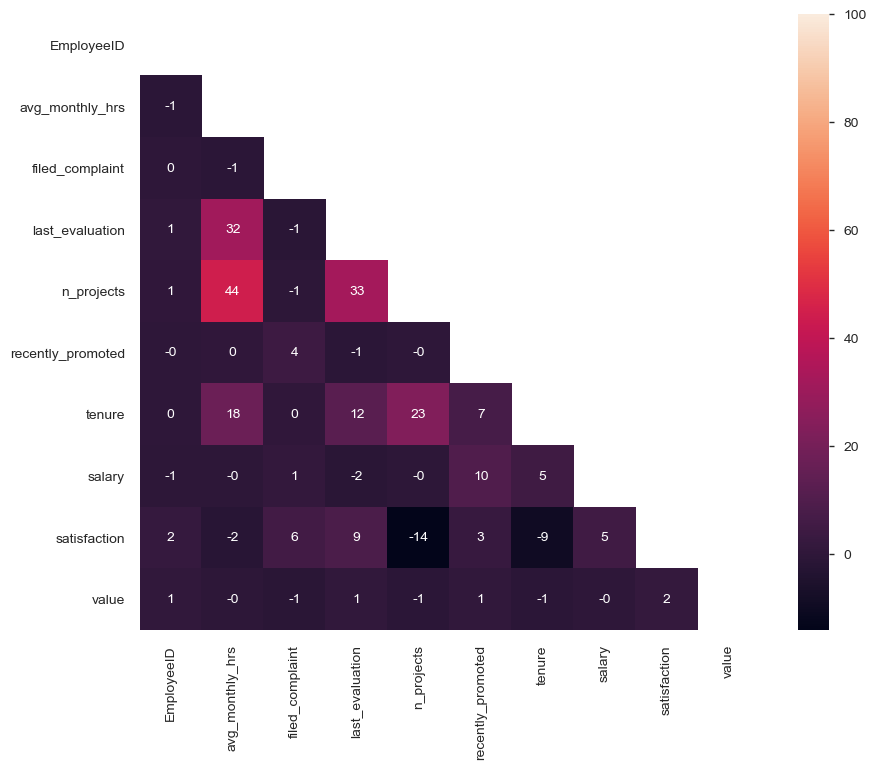

In [247]:
correlations = df.corr()
# Change color scheme
sns.set_style("white")

# Make the figsize 10 x 8
plt.figure(figsize=(10,8))

#Mask
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Plot heatmap of correlations, masked top right, and remove cross correlations
sns.heatmap(correlations * 100, annot=True, fmt='.0f', mask=mask)

### Feature Engineering and Categorical Features

In [248]:
# Summarize categorical features
df.describe(include=['object'])


department    status
count       14249     14249
unique         13         2
top         sales  Employed
freq         3923     10857

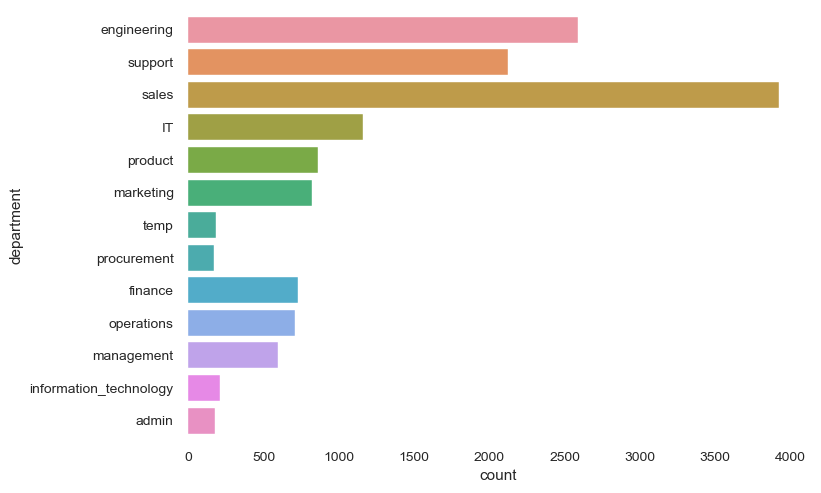

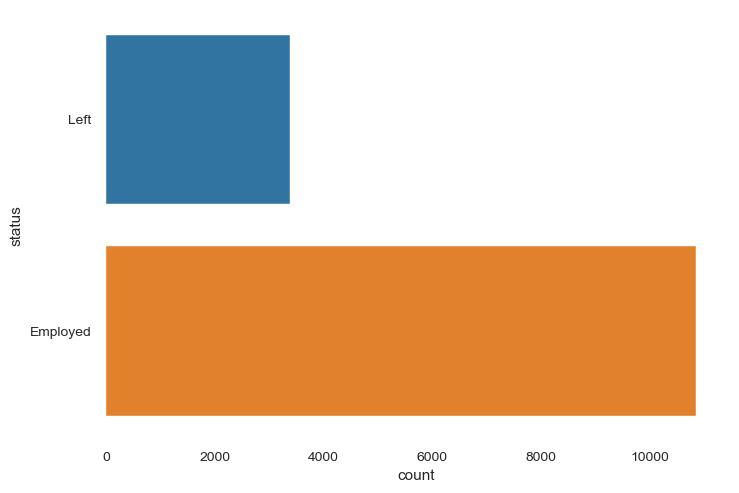

In [249]:
# Plot bar plot for each categorical feature
for feature in df.dtypes[df.dtypes == 'object'].index:
    sns.countplot(y=feature, data=df)
    plt.show()

### Inspect Segmentations

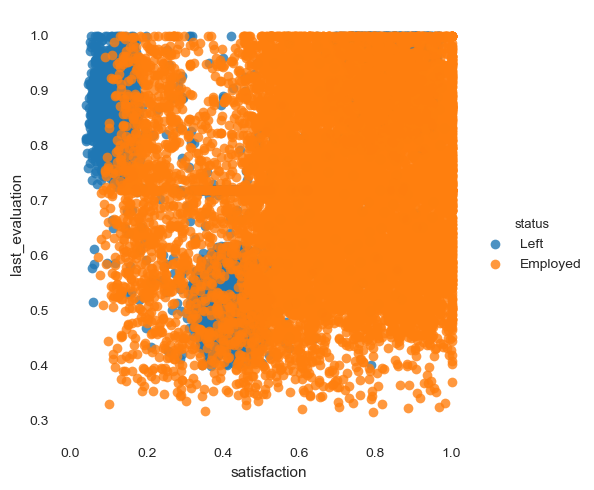

In [250]:
# Scatterplot of satisfaction vs. last_evaluation
sns.lmplot(x='satisfaction', y='last_evaluation', hue='status', data=df, fit_reg=False)

In [251]:
#import module
from sklearn.cluster import KMeans
# Filter data
left_emp =  df[['satisfaction', 'last_evaluation']]
# Create groups using K-means clustering.
kmeans = KMeans(n_clusters = 3, random_state = 0).fit(left_emp)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


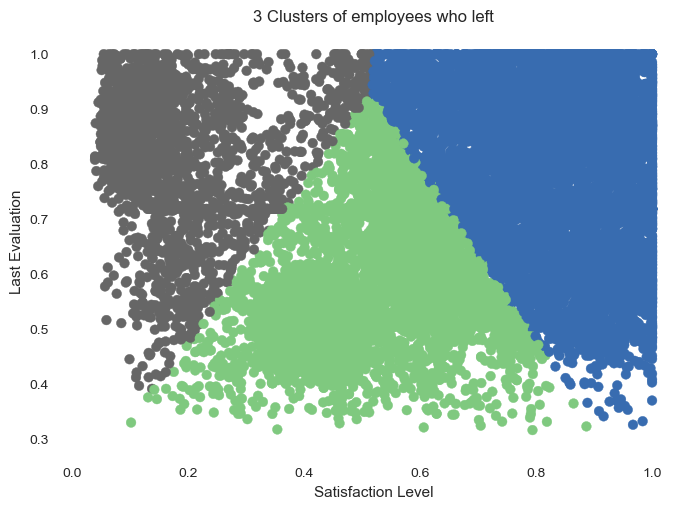

In [252]:
# Add new column "label" annd assign cluster labels.
left_emp['label'] = kmeans.labels_
# Draw scatter plot
plt.scatter(left_emp['satisfaction'], left_emp['last_evaluation'], c=left_emp['label'],cmap='Accent')
plt.xlabel('Satisfaction Level')
plt.ylabel('Last Evaluation')
plt.title('3 Clusters of employees who left')
plt.show()

### Last little bit of data cleaning preprocessing

In [253]:
# Unique classes of 'department'
df.department.unique()

array(['engineering', 'support', 'sales', 'IT', 'product', 'marketing',
       'temp', 'procurement', 'finance', 'operations', 'management',
       'information_technology', 'admin'], dtype=object)

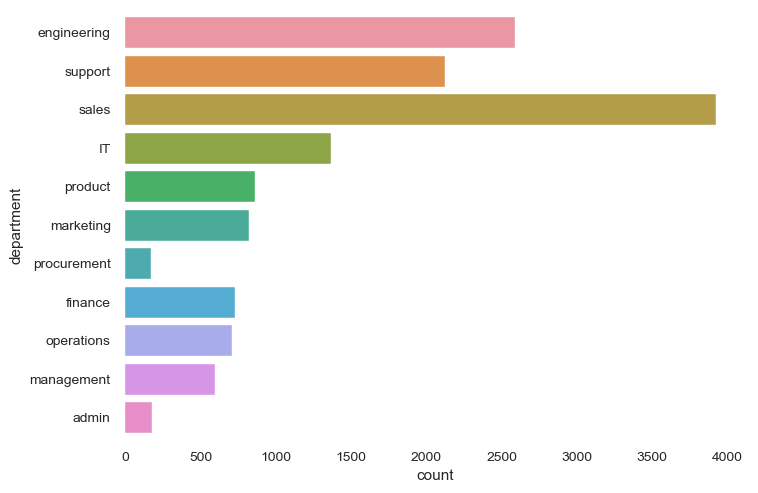

In [254]:
# 'information_technology' should be 'IT'
df.department.replace('information_technology', 'IT', inplace=True)
# Drop temporary workers
df = df[df.department != 'temp']

# Plot class distributions for 'department'
sns.countplot(y='department', data=df)

### Create Feature Groups

In [255]:
# Indicator variable for missing last_evaluation
df['last_evaluation_missing'] = df.last_evaluation.isnull().astype(int)
# Create indicator features
df['underperformer'] = ((df.last_evaluation < 0.6) & 
                        (df.last_evaluation_missing == 0)).astype(int)

df['unhappy'] = (df.satisfaction < 0.2).astype(int)

df['overachiever'] = ((df.last_evaluation > 0.8) & (df.satisfaction > 0.7)).astype(int)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [256]:
# The proportion of observations belonging to each group
df[['underperformer', 'unhappy', 'overachiever']].mean()

underperformer    0.285257
unhappy           0.092195
overachiever      0.177069
dtype: float64

In [257]:
df.head()

EmployeeID  avg_monthly_hrs   department  filed_complaint  last_evaluation  \
0           1              221  engineering              0.0         0.932868   
1           2              232      support              0.0         0.718477   
2           3              184        sales              0.0         0.788830   
3           4              206        sales              0.0         0.575688   
4           5              249        sales              0.0         0.845217   

   n_projects  recently_promoted    status  tenure  salary  satisfaction  \
0           4                0.0      Left     5.0       0      0.829896   
1           3                0.0  Employed     2.0       0      0.834544   
2           3                0.0  Employed     3.0       1      0.834988   
3           4                0.0  Employed     2.0       0      0.424764   
4           3                0.0  Employed     3.0       0      0.779043   

   value  last_evaluation_missing  underperformer  unhappy  overachiever  
0   65.0                        0               0        0             1  
1   47.0                        0               0        0             0  
2   41.0                        0               0        0             0  
3   97.0                        0               1        0             0  
4   49.0                        0               0        0             1

In [258]:
### Creating Dummy Variables
# Convert status to an indicator variable
df['status'] = pd.get_dummies( df.status ).Left
# Create new dataframe with dummy features
df = pd.get_dummies(df, columns=['department', 'salary'])
# Display first 10 rows
df.head(10)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


EmployeeID  avg_monthly_hrs  filed_complaint  last_evaluation  n_projects  \
0           1              221              0.0         0.932868           4   
1           2              232              0.0         0.718477           3   
2           3              184              0.0         0.788830           3   
3           4              206              0.0         0.575688           4   
4           5              249              0.0         0.845217           3   
5           6              140              0.0         0.589097           4   
6           7              121              1.0         0.625399           3   
7           8              150              0.0         0.644586           4   
8           9              215              1.0         0.524114           3   
9          10              269              0.0         0.909364           5   

   recently_promoted  status  tenure  satisfaction  value  \
0                0.0       1     5.0      0.829896   65.0   
1                0.0       0     2.0      0.834544   47.0   
2                0.0       0     3.0      0.834988   41.0   
3                0.0       0     2.0      0.424764   97.0   
4                0.0       0     3.0      0.779043   49.0   
5                0.0       0     4.0      0.660020   30.0   
6                0.0       0     3.0      0.835571   97.0   
7                0.0       0     3.0      0.796683   38.0   
8                0.0       0     7.0      0.715005   24.0   
9                0.0       0     2.0      0.994037   94.0   

   last_evaluation_missing  underperformer  unhappy  overachiever  \
0                        0               0        0             1   
1                        0               0        0             0   
2                        0               0        0             0   
3                        0               1        0             0   
4                        0               0        0             1   
5                        0               1        0             0   
6                        0               0        0             0   
7                        0               0        0             0   
8                        0               1        0             0   
9                        0               0        0             1   

   department_IT  department_admin  department_engineering  \
0              0                 0                       1   
1              0                 0                       0   
2              0                 0                       0   
3              0                 0                       0   
4              0                 0                       0   
5              0                 0                       0   
6              0                 0                       0   
7              0                 0                       1   
8              0                 0                       1   
9              0                 0                       0   

   department_finance  department_management  department_marketing  \
0                   0                      0                     0   
1                   0                      0                     0   
2                   0                      0                     0   
3                   0                      0                     0   
4                   0                      0                     0   
5                   0                      0                     0   
6                   0                      0                     0   
7                   0                      0                     0   
8                   0                      0                     0   
9                   0                      0                     0   

   department_operations  department_procurement  department_product  \
0                      0                       0                   0   
1                      0                       0                   0   
2                   

In [259]:
# The proportion of observations who 'Left'
df.status.mean()

0.23933750355416547

### Model Building

In [260]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline 

# Seaborn for easier visualization
import seaborn as sns
sns.set_style('darkgrid')

# Pickle for saving model files
import pickle

# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

# Import RandomForestClassifier and GradientBoostingClassifer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Function for splitting training and test set
from sklearn.model_selection import train_test_split

# Function for creating model pipelines
from sklearn.pipeline import make_pipeline

# StandardScaler
from sklearn.preprocessing import StandardScaler

# GridSearchCV
from sklearn.model_selection import GridSearchCV

# Classification metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

The Recursive Feature Elimination (RFE) works by recursively removing variables and building a model on those variables that remain. It uses the model accuracy to identify which variables (and combination of variables) contribute the most to predicting the target attribute.

Let’s use feature selection to help us decide which variables are significant that can predict employee turnover with great accuracy. There are total 18 columns in X, how about select 10?

### Select Target Varable and Input Features

In [261]:
# Create separate object for input features
df = df.drop('EmployeeID', axis=1)
df.head()

avg_monthly_hrs  filed_complaint  last_evaluation  n_projects  \
0              221              0.0         0.932868           4   
1              232              0.0         0.718477           3   
2              184              0.0         0.788830           3   
3              206              0.0         0.575688           4   
4              249              0.0         0.845217           3   

   recently_promoted  status  tenure  satisfaction  value  \
0                0.0       1     5.0      0.829896   65.0   
1                0.0       0     2.0      0.834544   47.0   
2                0.0       0     3.0      0.834988   41.0   
3                0.0       0     2.0      0.424764   97.0   
4                0.0       0     3.0      0.779043   49.0   

   last_evaluation_missing  underperformer  unhappy  overachiever  \
0                        0               0        0             1   
1                        0               0        0             0   
2                        0               0        0             0   
3                        0               1        0             0   
4                        0               0        0             1   

   department_IT  department_admin  department_engineering  \
0              0                 0                       1   
1              0                 0                       0   
2              0                 0                       0   
3              0                 0                       0   
4              0                 0                       0   

   department_finance  department_management  department_marketing  \
0                   0                      0                     0   
1                   0                      0                     0   
2                   0                      0                     0   
3                   0                      0                     0   
4                   0                      0                     0   

   department_operations  department_procurement  department_product  \
0                      0                       0                   0   
1                      0                       0                   0   
2                      0                       0                   0   
3                      0                       0                   0   
4                      0                       0                   0   

   department_sales  department_support  salary_0  salary_1  salary_2  
0                 0                   0         1         0         0  
1                 0                   1         1         0         0  
2                 1                   0         0         1         0  
3                 1                   0         1         0         0  
4                 1                   0         1         0         0

In [262]:
# Create separate object for target variable
y = df.status

# Create separate object for input features
X = df.drop('status', axis=1)

In [263]:
# Split X and y into train and test sets
#30% of Data for testing, stratified random sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=1234,
                                                    stratify=df.status)

# Print number of observations in X_train, X_test, y_train, and y_test
print( len(X_train), len(X_test), len(y_train), len(y_test) )

9847 4221 9847 4221


### Build Model Pipelines

In [264]:
# Pipeline dictionary
pipelines = {
    'l1' : make_pipeline(StandardScaler(), 
                         LogisticRegression(penalty='l1' , random_state=123)),
    'l2' : make_pipeline(StandardScaler(), 
                         LogisticRegression(penalty='l2' , random_state=123)),
    'rf' : make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
    'gb' : make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=123))
}

In [265]:
# List tuneable hyperparameters of our Logistic pipeline
pipelines['l1'].get_params()

{'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l1', random_state=123, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__max_iter': 100,
 'logisticregression__multi_class': 'ovr',
 'logisticregression__n_jobs': 1,
 'logisticregression__penalty': 'l1',
 'logisticregression__random_state': 123,
 'logisticregression__solver': 'liblinear',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False,
 'memory': None,
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'standardscaler__copy': True,
 'standardscaler__with_mean': Tru

In [266]:
# Logistic Regression hyperparameters
l1_hyperparameters = {
    'logisticregression__C' : np.linspace(1e-3, 1e3, 10),
}

l2_hyperparameters = {
    'logisticregression__C' : np.linspace(1e-3, 1e3, 10),
}
# Random Forest hyperparameters
rf_hyperparameters = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33]
}
# Boosted Tree hyperparameters
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators': [100, 200],
    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth': [1, 3, 5]
}

In [267]:
# Create hyperparameters dictionary
hyperparameters = {
    'l1' : l1_hyperparameters,
    'l2' : l2_hyperparameters,
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters
}

In [268]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(X_train, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

l1 has been fitted.
l2 has been fitted.
rf has been fitted.
gb has been fitted.


In [269]:
# Display best_score_ for each fitted model
for name, model in fitted_models.items():
    print( name, model.best_score_ )

l1 0.837615517416472
l2 0.837615517416472
rf 0.9762364171828983
gb 0.9752208794556718


### Model Validation and Performance

In [270]:
# Classification metrics
#Cross Validation Performanc
from sklearn.metrics import roc_curve, auc

In [271]:
# Predict classes using L1-regularized logistic regression 
pred = fitted_models['rf'].predict(X_test)

# Display first 10 predictions
pred[:10]

array([0, 0, 1, 1, 0, 0, 0, 1, 1, 0], dtype=uint8)

In [274]:
# Import confusion_matrix
from sklearn.metrics import confusion_matrix

# Display confusion matrix for y_test and pred
print( confusion_matrix(y_test, pred) )

[[3197   14]
 [  90  920]]


- How many observations were correctly predicted? 4221
- How many true positives were there? 920
- How many true negatives were there? 3197
- How many false positives were there? 14
- How many false negatives were there? 90

Accuracy : (True Positive / True Negatives) / total

Precision : True Positive / Test Positives

Recall : True Positives / Actual Positives

FI Score = 2(precisionRecall)/SUM(precision+ Recall)

FI will be close to 1 when precision and recal are close to 1, FI is good way to make sure both precision and recall are good

In [283]:
print("Accuracy: %.4f%%" % (((920 + 3197) / 4221)* 100))
print("Precision: %.4f%%" % ((920  /(14 + 920)* 100)))
print("Recall: %.4f%%" % ((920  /(90 + 920)* 100)))
print("True Negative Rate: %.4f%%" % ((14  /(3197 + 14)* 100)))

Accuracy: 97.5361%
Precision: 98.5011%
Recall: 91.0891%
True Negative Rate: 0.4360%


In [289]:
acc = (920 + 3197) / 4221
rec = 920  /(90 + 920)
pre = 920  /(14 + 920)
F1 = 2 * ((pre * rec) / (pre + rec))
print("F1 Score is : %.4f%%" % F1)

F1 Score is : 0.9465%


In [303]:
# Predict PROBABILITIES using L1-regularized logistic regression
pred = fitted_models['rf'].predict_proba(X_test)

# Get just the prediction for the positive class (1)
pred = [p[1] for p in pred]

# Display first 5 predictions
pred[:10]

[0.0, 0.0, 0.99, 1.0, 0.0, 0.0, 0.0, 0.97, 1.0, 0.0]

In [305]:
# Calculate ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(y_test, pred)
# Store fpr, tpr, thresholds in DataFrame and display last 10
pd.DataFrame({'FPR': fpr, 'TPR' : tpr, 'Thresholds' : thresholds}).tail(10)

FPR       TPR  Thresholds
76  0.111180  0.975248        0.09
77  0.131735  0.977228        0.08
78  0.147929  0.979208        0.07
79  0.172532  0.981188        0.06
80  0.201183  0.984158        0.05
81  0.241046  0.989109        0.04
82  0.301152  0.992079        0.03
83  0.395204  0.994059        0.02
84  0.564310  0.997030        0.01
85  1.000000  1.000000        0.00

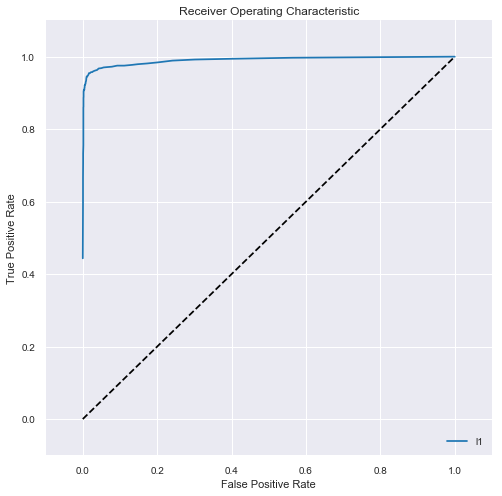

In [306]:
# Initialize figure
fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [307]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, pred)

# Calculate AUROC
print( auc(fpr, tpr) )

0.9904958512045536


### Can we Improve with XGBoost?

In [290]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [291]:
# Split X and y into train and test sets
#30% of Data for testing, stratified random sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=1234,
                                                    stratify=df.status)

# Print number of observations in X_train, X_test, y_train, and y_test
print( len(X_train), len(X_test), len(y_train), len(y_test) )

9847 4221 9847 4221


In [292]:
model = XGBClassifier()
model.fit(X_train,y_train)
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [294]:
predictions = model.predict(X_test)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [299]:
accuracy = accuracy_score(y_test, predictions)
accuracy

0.9682539682539683

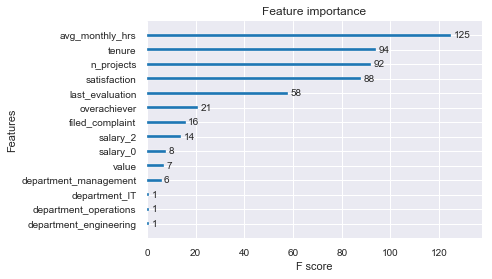

In [302]:
from matplotlib import pyplot as plt
from xgboost import plot_importance
plot_importance(model)
plt.show()